In [1]:
from pystac_client import Client
from pystac.extensions.eo import EOExtension as eo
import planetary_computer as pc
import geopandas as gpd
import h3
import pandas as pd

import rasterio
from rasterio import windows
from rasterio import features
from rasterio import warp
import rasterio.mask
from rasterio.enums import Resampling

import numpy as np
from PIL import Image

import matplotlib.pyplot as plt

from shapely.geometry import Point

from tqdm import tqdm

import os
import sys
module_path = os.path.abspath(os.path.join('../../'))
if module_path not in sys.path:
    sys.path.append(module_path)
    import aup

/home/edgaregurrola/.local/lib/python3.10/site-packages/geopandas/_compat.py:112: UserWarning: The Shapely GEOS version (3.10.2-CAPI-1.16.0) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  warnings.warn(
/home/edgaregurrola/.local/lib/python3.10/site-packages/osmnx/utils.py:192: UserWarning: The `utils.config` function is deprecated and will be removed in a future release. Instead, use the `settings` module directly to configure a global setting's value. For example, `ox.settings.log_console=True`.
  warnings.warn(


## Download data

### Municipality GeoDataFrame

(10, 6)


<AxesSubplot:>

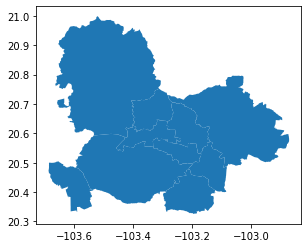

In [2]:
city = 'Guadalajara'
query = f"SELECT * FROM metropolis.metro_list WHERE \"city\" LIKE \'{city}\'"
mun_gdf = aup.gdf_from_query(query, geometry_col='geometry')
print(mun_gdf.shape)
mun_gdf.plot()

### Hex-bins GeoDataFrame

(1187, 2)


<AxesSubplot:>

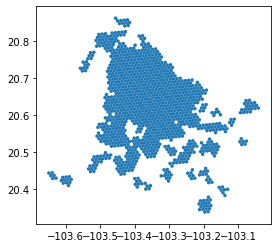

In [3]:
mpos = list(mun_gdf.CVEGEO.unique())

hex_ageb = gpd.GeoDataFrame()

schema = 'censo'
folder = 'hex_bins_pop_2020'

for m in mpos:
    query = f"SELECT hex_id_8,geometry FROM {schema}.{folder} WHERE \"CVEGEO\" LIKE \'{m}%%\'"
    hex_ageb = pd.concat([hex_ageb, 
                          aup.gdf_from_query(query, geometry_col='geometry')], 
                         ignore_index = True, axis = 0)

print(hex_ageb.shape)
hex_ageb.plot()

In [6]:
hex_ageb.head(2)

,hex_id_8,geometry
0,8849abc9ebfffff,"POLYGON ((-103.61319 20.42802, -103.61772 20.4..."
1,8849abc9e3fffff,"POLYGON ((-103.61374 20.43321, -103.61319 20.4..."


Create hexagons for area with population at different resolutions

In [8]:
hex_gdf = hex_ageb.copy()
hex_gdf.rename(columns={'hex_id_8':'hex_id'}, inplace=True)
hex_gdf['res'] = 8

for r in range(9,12):
    
    hex_tmp = aup.create_hexgrid(hex_ageb, r)
    hex_tmp.rename(columns={f'hex_id_{r}':'hex_id'}, inplace=True)
    hex_tmp['res'] = r
    
    hex_gdf = pd.concat([hex_gdf, hex_tmp], 
        ignore_index = True, axis = 0)
    
    del hex_tmp

In [10]:
print(hex_gdf.shape)
hex_gdf.head(2)

(474800, 3)


,hex_id,geometry,res
0,8849abc9ebfffff,"POLYGON ((-103.61319 20.42802, -103.61772 20.4...",8
1,8849abc9e3fffff,"POLYGON ((-103.61374 20.43321, -103.61319 20.4...",8


## Humidity index analysis

### Create boundaries for imagery download

In [11]:
# Reads mun_gdf GeoDataFrame as polygon
poly = hex_ageb.geometry
# Extracts coordinates from polygon as DataFrame
coord_val = poly.bounds
# Gets coordinates for bounding box
n = coord_val.maxy.max()
s = coord_val.miny.min()
e = coord_val.maxx.max()
w = coord_val.minx.min()

#### Generate polygon dictionary

In [12]:
area_of_interest = {
    "type": "Polygon",
    "coordinates": [
        [
            [e, s],
            [w, s],
            [w, n],
            [e, n],
            [e, s],
        ]
    ],
}

### Define time period for imagery

Since the api is limited to a max of 100 images, dates are divided in periods of 6 months.

In [13]:
time_of_interest = ["2020-01-01/2020-06-30","2020-07-01/2020-12-31",
                   "2021-01-01/2021-06-30","2021-07-01/2021-12-31",
                   "2022-01-01/2022-06-30"]

### Identify imagery

This section identifies satellite imagery that meets the requeirments for the Satellite (sentinel-2-l2a), area_of_interest, time_of_interest and limit for cloud cover (10%).

In [14]:
catalog = Client.open("https://planetarycomputer.microsoft.com/api/stac/v1")

items = []

for t in time_of_interest:
    search = catalog.search(
        collections=["sentinel-2-l2a"],
        intersects=area_of_interest,
        datetime=t,
        query={"eo:cloud_cover": {"lt": 10}},
    )

    # Check how many items were returned
    items.extend(list(search.get_items()))
print(f"Returned {len(items)} Items")

Returned 407 Items


### Gather links for imagery bands

Identify download links for Near Infrared (nir) and SWIR bands for each date that meets the requierments.

In [15]:
def find_asset_by_band_common_name(item, common_name):
    for asset in item.assets.values():
        asset_bands = eo.ext(asset).bands
        if asset_bands and asset_bands[0].common_name == common_name:
            return asset
    raise KeyError(f"{common_name} band not found")

Bands to analyze

In [16]:
vegetation = 'nir'
humidity = 'swir16'

In [17]:
assets_hrefs = {}

for i in items:
    if i.datetime.date() in list(assets_hrefs.keys()):
        assets_hrefs[i.datetime.date()][vegetation].append(pc.sign(find_asset_by_band_common_name(i,vegetation).href))
        assets_hrefs[i.datetime.date()][humidity].append(pc.sign(find_asset_by_band_common_name(i,humidity).href))
    else:
        assets_hrefs[i.datetime.date()] = {vegetation:[],
                                          humidity:[]}
        assets_hrefs[i.datetime.date()][vegetation].append(pc.sign(find_asset_by_band_common_name(i,vegetation).href))
        assets_hrefs[i.datetime.date()][humidity].append(pc.sign(find_asset_by_band_common_name(i,humidity).href))

Remove dates without insuficcient data

In [18]:
max_links_len = 0

# first determine max amount of satellite data 
for k_date in list(assets_hrefs.keys()):
    # gather data from first band in dictionary - the max value should be the same in all bands
    k_band = list(assets_hrefs[k_date].keys())[0]
    # compare len of that band to max
    if len(assets_hrefs[k_date][k_band]) > max_links_len:
        # if its higher this is the new high value
        max_links_len = len(assets_hrefs[k_date][k_band])
        
# iterate and remove dates without sufficient data
for k_date in list(assets_hrefs.keys()):
    # gather data from first band in dictionary - the max value should be the same in all bands
    k_band = list(assets_hrefs[k_date].keys())[0]
    # compare len of that band to max
    if len(assets_hrefs[k_date][k_band]) < max_links_len:
        # if len is less it indicates that is missing data
        # remove date with missing data
        assets_hrefs.pop(k_date)

Filter data by month

In [19]:
df_dates = pd.DataFrame.from_dict(assets_hrefs, orient='Index').reset_index().rename(columns={'index':'date'})
df_dates['date'] = pd.to_datetime(df_dates['date']).dt.date
df_dates['year'] = df_dates.apply(lambda row: row['date'].year, axis=1)
df_dates['month'] = df_dates.apply(lambda row: row['date'].month, axis=1)
print(df_dates.shape)
df_dates.head(4)

(86, 5)


,date,nir,swir16,year,month
0,2020-05-27,[https://sentinel2l2a01.blob.core.windows.net/...,[https://sentinel2l2a01.blob.core.windows.net/...,2020,5
1,2020-05-22,[https://sentinel2l2a01.blob.core.windows.net/...,[https://sentinel2l2a01.blob.core.windows.net/...,2020,5
2,2020-05-17,[https://sentinel2l2a01.blob.core.windows.net/...,[https://sentinel2l2a01.blob.core.windows.net/...,2020,5
3,2020-05-12,[https://sentinel2l2a01.blob.core.windows.net/...,[https://sentinel2l2a01.blob.core.windows.net/...,2020,5


Keep only one data point for each month

In [20]:
df_dates_filtered = pd.DataFrame()

for y in df_dates['year'].unique():
    for m in df_dates.loc[df_dates['year']==y,'month'].unique():
        df_dates_filtered = pd.concat([df_dates_filtered,
                                     df_dates.loc[(df_dates['year']==y)&
                                                  (df_dates['month']==m)].sample(1)],
                                      ignore_index=True)
print(df_dates_filtered.shape)
df_dates_filtered.head(4)

(24, 5)


,date,nir,swir16,year,month
0,2020-05-02,[https://sentinel2l2a01.blob.core.windows.net/...,[https://sentinel2l2a01.blob.core.windows.net/...,2020,5
1,2020-04-27,[https://sentinel2l2a01.blob.core.windows.net/...,[https://sentinel2l2a01.blob.core.windows.net/...,2020,4
2,2020-03-03,[https://sentinel2l2a01.blob.core.windows.net/...,[https://sentinel2l2a01.blob.core.windows.net/...,2020,3
3,2020-02-27,[https://sentinel2l2a01.blob.core.windows.net/...,[https://sentinel2l2a01.blob.core.windows.net/...,2020,2


## NIR

### Mosaic dataset

In [21]:
src_files_to_mosaic = []

for assets in df_dates_filtered.iloc[0][vegetation]:
    src = rasterio.open(assets)
    src_files_to_mosaic.append(src)
    
    # src.close()

In [22]:
from rasterio.merge import merge

mosaic_red, out_trans = merge(src_files_to_mosaic)

### Upscale raster when using NIR

In [24]:
out_meta = src.meta

out_meta.update({"driver": "GTiff",
                 "dtype": 'float32',
                 "height": mosaic_red.shape[1],
                 "width": mosaic_red.shape[2],
                 "transform": out_trans})

with rasterio.open("tmp/mosaic_nir.tif", "w", **out_meta) as dest:
    dest.write(mosaic_red)

    dest.close()
    
with rasterio.open("tmp/mosaic_nir.tif", "r") as ds:
    
    upscale_factor = 1/2
    
    mosaic_red = ds.read(
                out_shape=(
                    ds.count,
                    int(ds.height * upscale_factor),
                    int(ds.width * upscale_factor)
                ),
                resampling=Resampling.bilinear
            )
    
    ds.close()

In [31]:
mosaic_red.shape

(1, 10488, 10488)

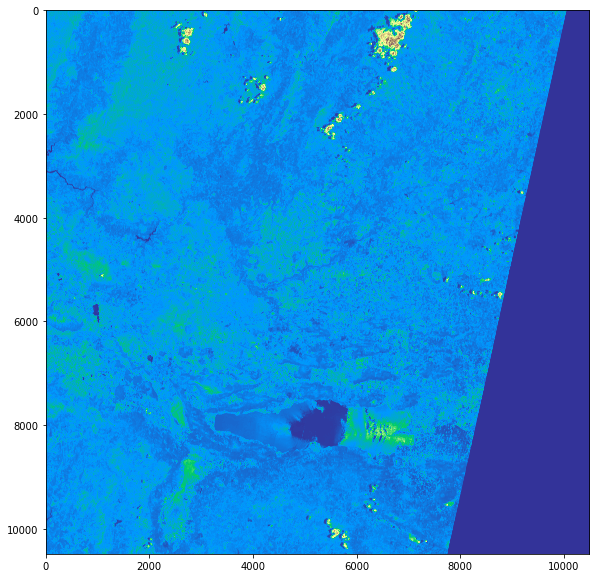

In [28]:
fig, ax = plt.subplots(figsize=(10,10))

plt.imshow(data[0], cmap="terrain");

## SWIR

### Mosaic dataset

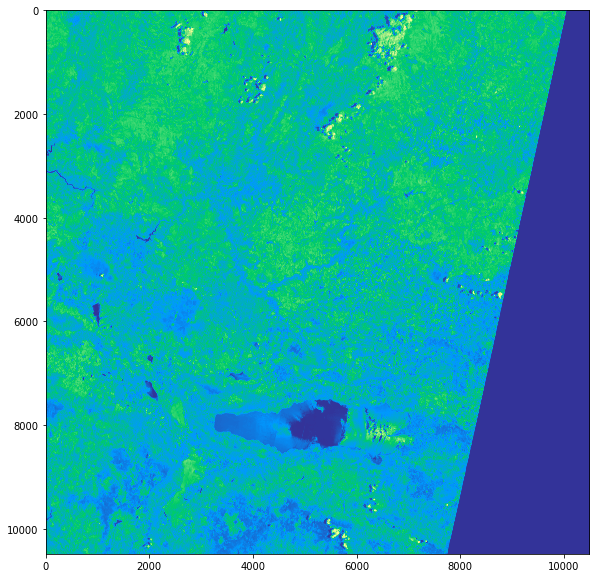

In [29]:
src_files_to_mosaic = []

for assets in df_dates_filtered.iloc[0][humidity]:
    src = rasterio.open(assets)
    src_files_to_mosaic.append(src)
    
mosaic_swir, out_trans = merge(src_files_to_mosaic)

fig, ax = plt.subplots(figsize=(10,10))

plt.imshow(mosaic_swir[0], cmap="terrain");

In [30]:
mosaic_swir.shape

(1, 10488, 10488)

Transform numpy array to float

In [23]:
mosaic_red = data.astype(float)
data = 0
mosaic_swir = mosaic_swir.astype(float)

### Calculating NDMI

In [32]:
ndmi = (mosaic_red-mosaic_swir)/(mosaic_red+mosaic_swir)

/tmp/ipykernel_58452/3626025282.py:1: RuntimeWarning: invalid value encountered in true_divide
  ndhi = (mosaic_red-mosaic_swir)/(mosaic_red+mosaic_swir)


In [33]:
ndmi.shape

(1, 10488, 10488)

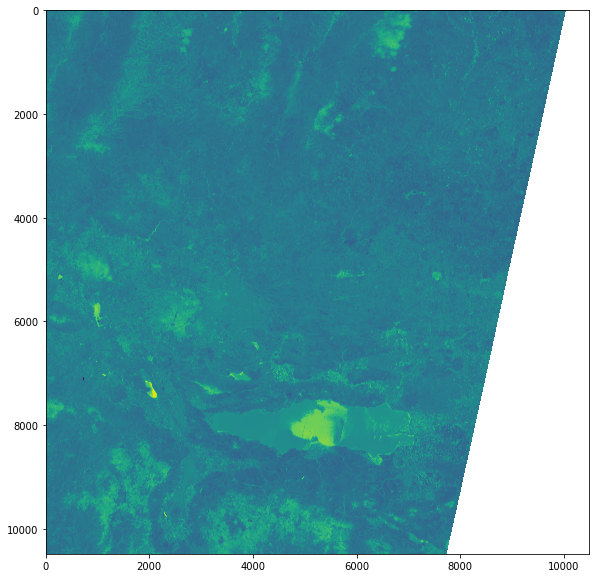

In [34]:
fig, ax = plt.subplots(figsize=(10,10))

plt.imshow(ndhi[0], cmap="viridis");

## Save NDMI

In [35]:
out_meta = src.meta

transform_ds = src.transform

out_meta.update({"driver": "GTiff",
                 "dtype": 'float32',
                 "height": ndmi.shape[1],
                 "width": ndmi.shape[2],
                 "transform": transform_ds})

with rasterio.open("tmp/ndmi.tif", "w", **out_meta) as dest:
    dest.write(ndmi)

    dest.close()

## Intersect Raster and Hexagons

### Testing

In [36]:
ndmi_file = rasterio.open("tmp/ndmi.tif")

In [39]:
ndmi_file.crs

CRS.from_epsg(32613)

In [40]:
def clean_mask(geom, dataset=ndmi_file, **mask_kw):
    mask_kw.setdefault('crop', True)
    mask_kw.setdefault('all_touched', True)
    mask_kw.setdefault('filled', False)
    masked, mask_transform = rasterio.mask.mask(dataset=dataset, shapes=(geom,),
                                  **mask_kw)
    return masked, mask_transform

In [53]:
# hex_ndmi = hex_gdf.loc[hex_gdf.res==8].copy()
hex_ndmi = hex_ageb.copy()
hex_ndmi = hex_ndmi.to_crs("EPSG:32613")

In [54]:
hex_ndmi.head(2)

,hex_id_8,geometry
0,8849abc9ebfffff,"POLYGON ((644682.094 2259457.936, 644212.680 2..."
1,8849abc9e3fffff,"POLYGON ((644619.862 2260032.269, 644682.094 2..."


<AxesSubplot:>

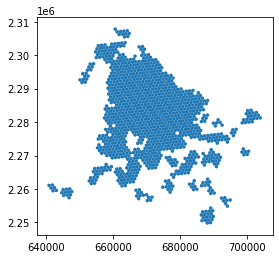

In [55]:
hex_ndmi.plot()

In [56]:
hex_ndmi['ndmi'] = hex_ndmi.geometry.apply(clean_mask).apply(np.ma.mean)

ValueError: Input shapes do not overlap raster.

In [ ]:
fig, ax = plt.subplots(figsize=(10,10))

hex_ndmi.plot('ndmi', legend=True, ax=ax)

## Interpolate missing data

In [25]:
hex_ageb.to_file('tmp/hex_ageb.geojson', driver='GeoJSON')